# Example PrivacyFingerprint Workflow

This notebook walks you through a potential end-to-end workflow, to introduce a user to how each component can be loaded and how they can be configured

In [70]:
import os
import sys
from spacy import displacy

path_root = os.path.dirname(os.getcwd())

if path_root not in sys.path:
    sys.path.append(path_root)

In [71]:
from src.generate.synthea import GenerateSynthea
from src.generate.llm import GenerateLLM
from src.extraction.extraction import Extraction
from src.standardise_extraction.standardise_extraction import (
    StandardiseExtraction,
)
from src.privacy_risk_scorer.privacy_risk_scorer import PrivacyRiskScorer
from src.privacy_risk_explainer.privacy_risk_explainer import (
    PrivacyRiskExplainer,
)

from src.config.experimental_config import load_experimental_config
from src.config.global_config import load_global_config

### Importing and Loading Global and Experimental Config

**global_config_path**  this is the location of the global config path and then the output folder name is redefined to ensure the example experiments are out in the open. (Normally the default output folder should be used for your own experiments.)

**default_config_path** is given so the user can point to the default experimental config values. Currently the pipeline copies the original experimental config down into the folder, and if this exists, only uses the experimental config defined in that folder.

In [72]:
# Loads global config and redefines the outputs to go to an example_output (normally default to an outputs folder which is git ignored in this repo.)
global_config_path = "../config/global_config.yaml"
global_config = load_global_config(global_config_path)
global_config.output_paths.output_folder = "../example_output"


default_config_path = "../config/experimental_config.yaml"
experimental_config = load_experimental_config(default_config_path)
experimental_config.outputs.experiment_name = "pipeline_1000_19_08_24"
experimental_folder = f"{global_config.output_paths.output_folder}/{experimental_config.outputs.experiment_name}"

# Privacy Fingerprint End-to-End Overview

The Pipeline has been broken down into four components:
1. **GenerateSynthea**: This generates a list of dictionary of synthetic patient records.
2. **GenerateLLM**: This generates medical notes using the outputs created from **GenerateSynthea**.
3. **Extraction**: This currently uses an LLM that is specialised to extract given entities from the synthetic medical notes produced by **GenerativeLLM**
4. **StandardiseExtraction**: This standardises the results extracted from the medical text.
5. **PrivacyRiskScorer**: This scores the uniqueness of standardised entity values extracted.
6. **PrivacyRiskExplainer**: Takes in the predicted transformed values, and transformed dataset generater from the gaussian copula, and calculates shapley values. 

Additionally each class will also take a path for the input required to create their output. This allows the user to break-up the pipeline and run from specific points in the pipeline.

## 1. GenerateSynthea: Generating Synthetic Patient Data using Synthea 

Synthea-international is an expansion of Synthea, which is an open-source synthetic patient generator that produces de-identified health records for synthetic patients.

GenerateSynthea is a class used to run Synthea. You will need to follow the instructions on the README to ensure Synthea is installed.

In [73]:
experimental_config.synthea.path_output = f"{experimental_folder}/synthea.json"
experimental_config.synthea.population_num = "1000"

In [74]:
output_synthea = GenerateSynthea(
    global_config=global_config, syntheaconfig=experimental_config.synthea
).run_or_load()
output_synthea

[{'NHS_NUMBER': '1963285395',
  'DATE_OF_BIRTH': '2024-06-19',
  'GIVEN_NAME': 'Fidel',
  'FAMILY_NAME': 'Gleichner',
  'DIAGNOSIS': nan},
 {'NHS_NUMBER': '3473245801',
  'DATE_OF_BIRTH': '2012-05-02',
  'GIVEN_NAME': 'Cleo',
  'FAMILY_NAME': 'Walter',
  'DIAGNOSIS': 'Otitis media'},
 {'NHS_NUMBER': '9274572891',
  'DATE_OF_BIRTH': '2009-09-19',
  'GIVEN_NAME': 'Arletta',
  'FAMILY_NAME': 'Batz',
  'DIAGNOSIS': 'Acute viral pharyngitis (disorder)'},
 {'NHS_NUMBER': '3264124556',
  'DATE_OF_BIRTH': '2007-11-23',
  'GIVEN_NAME': 'Fidel',
  'FAMILY_NAME': 'Jast',
  'DIAGNOSIS': 'Seizure disorder'},
 {'NHS_NUMBER': '8098647005',
  'DATE_OF_BIRTH': '2007-09-10',
  'GIVEN_NAME': 'Rosalva',
  'FAMILY_NAME': 'Wintheiser',
  'DIAGNOSIS': 'Fracture of forearm'},
 {'NHS_NUMBER': '4298257150',
  'DATE_OF_BIRTH': '2008-03-09',
  'GIVEN_NAME': 'Garret',
  'FAMILY_NAME': 'Kuphal',
  'DIAGNOSIS': 'Atopic dermatitis'},
 {'NHS_NUMBER': '0706254457',
  'DATE_OF_BIRTH': '2020-06-09',
  'GIVEN_NAME': 'Mill

In [75]:
NHS_number_set = set([N["NHS_NUMBER"] for N in output_synthea])
print(len(NHS_number_set))

954


## 2. GenerateLLM: Generating Synthetic Patient Medical Notes 

This component uses a LLM model either hosted via Ollama to generate synthetic patient medical notes depending on the prompt template given below.

### Create Prompt Templates used in the Experimental Pipeline.

This defines the template you want the generate component to use. In this example we use Llama2, and this is a prompt template that can be used to support this.

In [76]:
# Functions needed to create prompt templates and save them for the experiments.
from src.config.prompt_template_handler import (
    save_generate_template_to_json,
    load_and_validate_generate_prompt_template,
)

# Defines the path of where llama3 template lives in the generate folder.
# A llama2 template can also be used. However, you will need to change the experimental config.
generate_template_path = (
    f"{global_config.output_paths.generate_template}llama3_template.json"
)

# This defines a template used by LLama3
generate_template = """<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
You are a medical student answering an exam question about writing clinical notes for patients.
<|eot_id|>

<|start_header_id|>user<|end_header_id|>
Keep in mind that your answer will be accessed based on incorporating all the provided information and the quality of prose.

1. Use prose to write an example clinical note for this patient's doctor.
2. Use less than three sentences.
3. Do not provide recommendations.
4. Use the following information:

{data}
<|eot_id|>

<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

# Saves the template to the path defined.
save_generate_template_to_json(
    template_str=generate_template, file_path=generate_template_path
)

# Loads the template so the user can inspect the template saved.
loaded_generate_template = load_and_validate_generate_prompt_template(
    filename=generate_template_path
)
print(loaded_generate_template)

Template saved to '../config/templates/generatellama3_template.json'
<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
You are a medical student answering an exam question about writing clinical notes for patients.
<|eot_id|>

<|start_header_id|>user<|end_header_id|>
Keep in mind that your answer will be accessed based on incorporating all the provided information and the quality of prose.

1. Use prose to write an example clinical note for this patient's doctor.
2. Use less than three sentences.
3. Do not provide recommendations.
4. Use the following information:

{data}
<|eot_id|>

<|eot_id|><|start_header_id|>assistant<|end_header_id|>



This runs GenerateLLM using the synthea output from the previous run, and saves the LLM output to the given path_output_llm.

You can set **verbose** to true or false depending on whether you want outputs to print to the screen on run. 

In [77]:
experimental_config.generate.synthea_path = (
    experimental_config.synthea.path_output
)
experimental_config.generate.path_output = f"{experimental_folder}/llm.json"

In [78]:
output_llm = GenerateLLM(
    global_config=global_config, generateconfig=experimental_config.generate
).run_or_load()
output_llm

["Here is a clinical note for the patient's doctor:\n\n**Patient Information:**\nNHS Number: 19632-85395\nDate of Birth: June 19, 2024\n\n**Clinical Note:**\n\nFidel Gleichner presented with [insert relevant symptoms or issues]. The patient's chief complaint is [state specific issue]. On examination, I noted [relevant physical findings].\n\nPlease note that this is a brief example and may need to be expanded upon for a comprehensive clinical note.",
 "Here is a clinical note example:\n\nMay 15, 20XX\n\nPatient Cleo Walter, born May 2, 2012 (NHS number: 34732-45-801), was seen today with a diagnosis of otitis media. Her symptoms include [insert specific symptoms if known]. The patient's condition is currently being managed as per her doctor's orders.",
 'Here is an example clinical note:\n\n9274572891, Arletta Batz, born 2009-09-19. Admitted with symptoms of acute viral pharyngitis. Currently presenting with sore throat and fever. Further evaluation and treatment to be determined.',
 'C

## 3. Extraction: Re-extracting Entities from the Patient Medical Notes

This uses a package called GliNER to extract out entities from the synthetic medical notes.

Changing inputs to the **experimental_config.extraction.entity_list** allows you to look for more entities

In [79]:
experimental_config.extraction.llm_path = (
    experimental_config.generate.path_output
)
experimental_config.extraction.path_output = (
    f"{experimental_folder}/extraction.json"
)
experimental_config.extraction.entity_list = [
    "nhs number",
    "person",
    "date of birth",
    "diagnosis",
]
experimental_config.extraction.server_model_type = "gliner"

In [98]:
output_extraction = Extraction(
    global_config=global_config,
    extractionconfig=experimental_config.extraction,
).run_or_load()
output_extraction

[{'Entities': [{'start': 76,
    'end': 86,
    'text': 'NHS Number',
    'label': 'nhs number',
    'score': 0.8144140243530273},
   {'start': 88,
    'end': 99,
    'text': '19632-85395',
    'label': 'nhs number',
    'score': 0.9539685249328613},
   {'start': 115,
    'end': 128,
    'text': 'June 19, 2024',
    'label': 'date of birth',
    'score': 0.9813476800918579},
   {'start': 150,
    'end': 165,
    'text': 'Fidel Gleichner',
    'label': 'person',
    'score': 0.9659422636032104}]},
 {'Entities': [{'start': 34,
    'end': 46,
    'text': 'May 15, 20XX',
    'label': 'date of birth',
    'score': 0.5515469908714294},
   {'start': 48,
    'end': 67,
    'text': 'Patient Cleo Walter',
    'label': 'person',
    'score': 0.9412822723388672},
   {'start': 74,
    'end': 85,
    'text': 'May 2, 2012',
    'label': 'date of birth',
    'score': 0.9512800574302673},
   {'start': 87,
    'end': 97,
    'text': 'NHS number',
    'label': 'nhs number',
    'score': 0.631360411643981

In [99]:
NHS_Number_count = 0
NHS_Number_in_Set_Count = 0

for item in output_extraction:
    entities = item["Entities"]
    for e in entities:
        if e["label"] == "nhs number":
            NHS_Number_count += 1
            if e["text"] in NHS_number_set:
                NHS_Number_in_Set_Count += 1

print(NHS_Number_count, NHS_Number_in_Set_Count)

1006 104


In [120]:
NHS_number_ents = []
review_count = 0

for item in output_extraction:
    entities = item["Entities"]
    labels = [e["label"] for e in entities]
    if labels.count("nhs number") > 1:
        review_count += 1
        for e in entities:
            if e["label"] == "nhs number":
                NHS_number_ents.append(e["text"])

review_count

308

In [124]:
review_count = 0
ids = []

for id, item in enumerate(output_extraction):
    entities = item["Entities"]
    labels = [e["label"] for e in entities]
    if labels.count("nhs number") == 0:
        review_count += 1
        ids.append(id)

print(review_count)

256


In [125]:
len(NHS_number_ents)

616

### Visualising Entities using DisplaCy

This visualises the entities in an example clinical note using DisplaCy.

We format the extracted entities into a dictionary compatable with DisplaCy, and display the string.

In [ ]:
for string_id in ids[0:9]:

    ents_dict = {
        "text": output_llm[string_id],
        "ents": output_extraction[string_id]["Entities"],
    }

    displacy.render(ents_dict, manual=True, style="ent")

## 4. StandardiseExtraction: Normalising Entities Extracted for Scoring

This takes in the above List of Dictionary entities and begins to normalise the responses into a dataframe format.

The standardisation process is broken down into many parts:
1. Entities are extracted from the object created from **Extraction**, and a set of functions can be applied to clean them during this process.
2. This creates a list of cleaned entities. Multiple entities can be extracted from the same person for a given entity type, for example diagnosis. Currently the codebase only takes the first entity given.
3. Next the outputs are normalised i.e. Dates can be written in multiple formats but have the same meaning.
4. Lastly the data is encoded and formatted as a numpy array ready for PyCorrectMatch

In the src/config.py file:

extra_preprocess_functions_per_entity defines how entities are cleaned while extracted from the extraction_output.

```
extra_preprocess_functions_per_entity = {"person": [clean_name.remove_titles]}
```

standardise_functions_per_entity defines how entities are extracted, and defines any normalisation process you may want on a column of entities.
```
standardise_functions_per_entity = {
    "person": [extract_first_entity_from_list],
    "nhs number": [extract_first_entity_from_list],
    "date of birth": [
        extract_first_entity_from_list,
        normalise_columns.normalise_date_column,
    ],
    "diagnosis": [extract_first_entity_from_list],
}
```

This uses the output_extraction value created by the **Extraction** class and saves the outputs of the normalisation process as a .csv to the given path.

In [13]:
path_output_standardisation = f"{experimental_folder}/standardisation.csv"

In [14]:
output_standards = StandardiseExtraction(
    extraction_input=output_extraction,
    path_output=path_output_standardisation,
    save_output=True,
).run()
output_standards

,person,nhs number,date of birth,diagnosis
0,401,241,690,0
1,16,288,0,126
2,172,207,461,75
3,402,241,439,0
4,777,183,435,17
...,...,...,...,...
949,290,0,196,113
950,907,0,125,9
951,382,0,585,74
952,96,16,15,74


This loads an extraction input from the extraction_path provided, and creates the output_standards.

In [15]:
output_standards = StandardiseExtraction(
    extraction_path=experimental_config.extraction.path_output,
    path_output=path_output_standardisation,
    save_output=False,
).run()
output_standards

,person,nhs number,date of birth,diagnosis
0,401,241,690,0
1,16,288,0,126
2,172,207,461,75
3,402,241,439,0
4,777,183,435,17
...,...,...,...,...
949,290,0,196,113
950,907,0,125,9
951,382,0,585,74
952,96,16,15,74


This loads a pre-saved output_standards from the given path provided.

In [16]:
output_standards = StandardiseExtraction(
    path_output=path_output_standardisation
).load()
output_standards

,person,nhs number,date of birth,diagnosis
0,401,241,690,0
1,16,288,0,126
2,172,207,461,75
3,402,241,439,0
4,777,183,435,17
...,...,...,...,...
949,290,0,196,113
950,907,0,125,9
951,382,0,585,74
952,96,16,15,74


In [135]:
output_standards["nhs number"].value_counts()

nhs number
0      256
241    253
288     44
240      3
397      3
      ... 
159      1
345      1
50       1
245      1
69       1
Name: count, Length: 399, dtype: int64

## 5. PrivacyRiskScorer: This scores the uniqueness of standardised entity values extracted.

In [17]:
try:
    scorer = PrivacyRiskScorer(
        scorer_config=experimental_config.pycorrectmatch
    )
except ValueError as e:
    print(e)

[ Info: Julia version info


Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.4 LTS
  uname: Linux 5.15.153.1-microsoft-standard-WSL2 #1 SMP Fri Mar 29 23:14:13 UTC 2024 x86_64 x86_64
  CPU: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz: 
                 speed         user         nice          sys         idle          irq
       #1-16  2495 MHz     672517 s         10 s      10926 s    1350955 s          0 s
  Memory: 31.203445434570312 GB (22667.32421875 MB free)
  Uptime: 12725.84 sec
  Load Avg:  0.23  0.5  1.45
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, tigerlake)
  Threads: 1 on 16 virtual cores
Environment:
  HOME = /home/will
  TERM = xterm-color
  PATH = /mnt/c/Users/Will Poulett/Documents/PrivFingerprint/privfp-experiments/.venv/bin:/home/will/.vscode-server/bin/fee1edb8d6d72a0ddff41e5f71a671c23ed924b9/bin/remote-cli:/home/linuxbrew/.linuxbrew/bin:/home/linuxbrew/.linuxbrew/sbin:/usr/local/sbin:/usr/

[ Info: Julia executable: /home/will/julia-1.8.1/bin/julia
[ Info: Trying to import PyCall...
┌ Warning: PyCall is already installed.  However, you may have trouble using
│ this Python executable because it is statically linked to libpython.
│ 
│ For more information, see:
│     https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
│ 
│ Python executable:
│     /mnt/c/Users/Will Poulett/Documents/PrivFingerprint/privfp-experiments/.venv/bin/python
│ Julia executable:
│     /home/will/julia-1.8.1/bin/julia
└ @ Main /mnt/c/Users/Will Poulett/Documents/PrivFingerprint/privfp-experiments/.venv/lib/python3.11/site-packages/julia/install.jl:90


In [188]:
# Here we fit the model, this has to happen first before calculating scores or transforming
scorer.fit(output_standards)
# This is the transformed dataset from the real record values to the marginal values
transformed_dataset = scorer.map_records_to_copula(output_standards)
N_FEATURES = output_standards.shape[1]

In [189]:
transformed_dataset

,person,nhs number,date of birth,diagnosis
0,643,2,490,5
1,644,3,1,4
2,645,109,491,6
3,646,2,492,5
4,647,256,493,22
...,...,...,...,...
949,323,1,267,30
950,324,1,268,11
951,325,1,13,2
952,326,183,489,2


In [184]:
unique_scores = []
for i, row in transformed_dataset.iterrows():
    # try:
    unique_scores.append(
        scorer.score_func(list(row))
    )  # get_individual_uniqueness BREAKS
# except KeyError as e:
#    print("ERROR:", e)
#    print(list(row))

In [190]:
transformed_dataset["score"] = scorer.predict_transformed(transformed_dataset)

In [191]:
transformed_dataset

,person,nhs number,date of birth,diagnosis,score
0,643,2,490,5,0.999985
1,644,3,1,4,0.999828
2,645,109,491,6,1.000000
3,646,2,492,5,0.999986
4,647,256,493,22,1.000000
...,...,...,...,...,...
949,323,1,267,30,0.999998
950,324,1,268,11,0.999994
951,325,1,13,2,0.999867
952,326,183,489,2,1.000000


In [192]:
import numpy as np

print(np.min(transformed_dataset["score"]))

0.9981858845336131


## 6. PrivacyRiskExplainer: Takes in the predicted transformed values, and transformed dataset generater from the gaussian copula, and calculates shapley values. 

In [141]:
# SHAP takes a while to run - a progress bar appears when running SHAP
try:
    explainer = PrivacyRiskExplainer(
        scorer.predict_transformed,
        N_FEATURES,
        explainer_config=experimental_config.explainers,
    )
except ValueError as e:
    print(e)

# Calculating shapley values using the transformed_dataset
local_shapley_df, global_shap, exp_obj = explainer.explain(transformed_dataset)

ExactExplainer explainer: 955it [07:56,  1.96it/s]                         


In [20]:
global_shap

person           0.000653
nhs number       0.000570
date of birth    0.001445
diagnosis        0.000873
dtype: float64

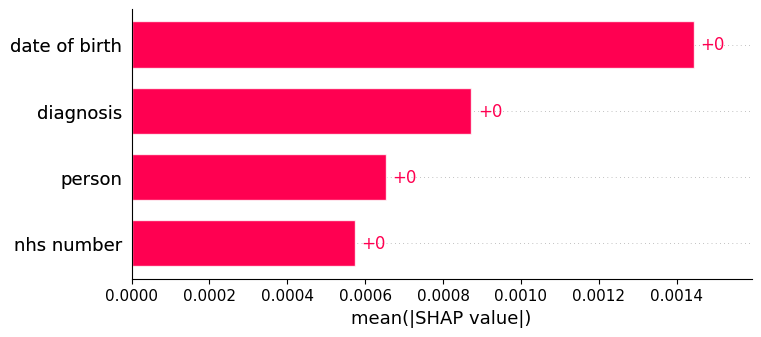

In [21]:
# Plot the mean shap values - global explanation
explainer.plot_global_explanation(exp_obj)

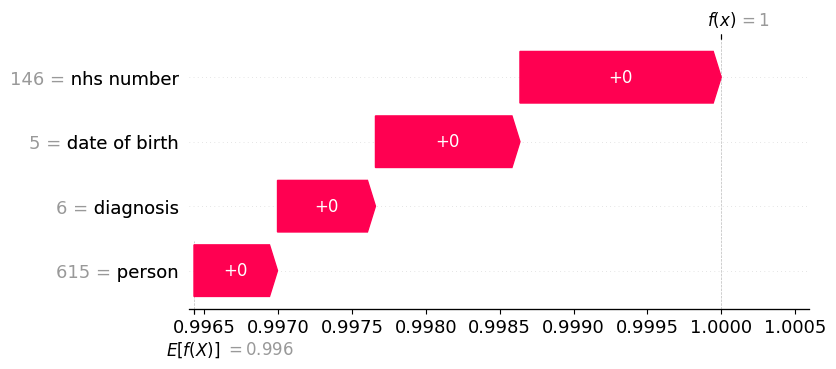

In [22]:
# Plot the local shap values for a particular record
explainer.plot_local_explanation(exp_obj, 49)

## 7. PyCanon 

Pycanon asseses the values of common privacy measuring metrics, such as K-Anonymity, I-Diversity and t-Closeness. 

For more information on these metrics see `docs/pycanon/pycanon_and_privacy_metrics.md`

In [23]:
identifiers = experimental_config.pycanon.identifiers
quasi_identifiers = experimental_config.pycanon.quasi_identifiers
sensitive_attributes = experimental_config.pycanon.sensitive_attributes

In [24]:
from pycanon.anonymity import k_anonymity, t_closeness, l_diversity

print("K-Anonymity: ", k_anonymity(output_standards, quasi_identifiers))
print(
    "t-Closeness: ",
    t_closeness(output_standards, quasi_identifiers, sensitive_attributes),
)
print(
    "l-Diversity: ",
    l_diversity(output_standards, quasi_identifiers, sensitive_attributes),
)

K-Anonymity:  1
t-Closeness:  0.5015651474684816
l-Diversity:  1
